## Histopathologic Cancer Detection

Using the PatchCamelyon (PCam) dataset, the goal is to build a model that can identify metastatic cancer in images that are taken from digital pathology scans.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from glob import glob

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D
from keras.layers import Flatten, BatchNormalization, Activation, AveragePooling2D
import numpy as np
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Import the test and train data

In [2]:
train_folder = "/kaggle/input/histopathologic-cancer-detection/train/"
test_folder = "/kaggle/input/histopathologic-cancer-detection/test/"

train_labels = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

df_test = pd.DataFrame({'filename': glob(os.path.join(test_folder, '*.tif'))})
df_test['id'] = df_test.filename.map(lambda x:x.split('/')[5])

df_train = train_labels
df_train['label'] = df_train['label'].astype(str)
df_train['id'] = df_train['id'] + '.tif'


## EDA

The dataset contains 220025 images, each of which is labeled 1 (cancer) or 0 (not cancer). There are 89117 positive images and 130908 negative.

In [3]:
df_train.describe()

,id,label
count,220025,220025
unique,220025,2
top,a81f84895ddcd522302ddf34be02eb1b3e5af1cb.tif,0
freq,1,130908


In [4]:
df_test.head()

,filename,id
0,/kaggle/input/histopathologic-cancer-detection...,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,/kaggle/input/histopathologic-cancer-detection...,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,/kaggle/input/histopathologic-cancer-detection...,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,/kaggle/input/histopathologic-cancer-detection...,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,/kaggle/input/histopathologic-cancer-detection...,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


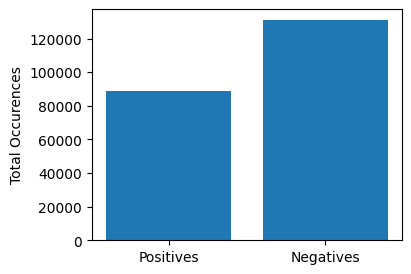

['Positives', 'Negatives'] [89117, 130908]


In [5]:
neg = (df_train['label'] == '0').sum()

pos = (df_train['label'] == '1').sum()

x = ["Positives", "Negatives"]
y = [pos, neg]

print()

fig = plt.figure(figsize=(4,3))

plt.bar(x,y)
plt.ylabel("Total Occurences")
plt.show()

print(x,y)

For time sake, I will be training the model on only the first 2000 images.

In [6]:
df_train = df_train.head(2000)

## Building the model

The architecture for the first model will be a convolutional layer followed by a max pool layer, then 2 convolutional layers followed by a max pool layer.

The second model will add a convolutional layer to each repetition as well as introduce batch normalization between the convolutional layers. It will also use average pooling and add another convolutional layer.

In [7]:
batch_size = 256

In [22]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.build(input_shape=(batch_size, 64, 64, 3))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (256, 62, 62, 16)      │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (256, 31, 31, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (256, 29, 29, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (256, 27, 27, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (256, 13, 13, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (256, 5408)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (256, 256)             │     1,384,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (256, 1)               │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,399,297 (5.34 MB)

 Trainable params: 1,399,297 (5.34 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
img_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

data_train = img_gen.flow_from_dataframe(
    dataframe = df_train,
    batch_size=batch_size,
    x_col='id',
    y_col='label',
    directory=train_folder,
    subset='training',
    class_mode='binary',
    target_size=(64, 64))

data_validate=img_gen.flow_from_dataframe(
    dataframe=df_train,
    batch_size=batch_size,
    x_col='id', 
    y_col='label', 
    directory=train_folder,
    subset="validation",
    class_mode='binary',
    target_size=(64, 64))

Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


Compile and fit the model to the training data

In [23]:
opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
hist = model.fit(data_train, validation_data=data_validate, epochs=10)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 436ms/step - accuracy: 0.5942 - loss: 0.6732 - val_accuracy: 0.5850 - val_loss: 0.6660
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.6061 - loss: 0.6555 - val_accuracy: 0.5850 - val_loss: 0.6562
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.6016 - loss: 0.6479 - val_accuracy: 0.5925 - val_loss: 0.6439
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.5991 - loss: 0.6342 - val_accuracy: 0.6125 - val_loss: 0.6292
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.6396 - loss: 0.6136 - val_accuracy: 0.6450 - val_loss: 0.6135
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.6783 - loss: 0.5968 - val_accuracy: 0.6600 - val_loss: 0.5946
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.7093 - loss: 0.5819 - val_accuracy: 0.6700 - val_loss: 0.5895
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.6964 - loss: 0.5746 - val_accuracy: 0.6775 - val_loss: 0.568

## Building the Second Model

In [19]:
new_model = Sequential()
    
new_model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
new_model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
new_model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
new_model.add(MaxPool2D(pool_size=(2,2)))
    
new_model.add(BatchNormalization())
new_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
new_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
new_model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
new_model.add(AveragePooling2D(pool_size=(2,2)))
    
new_model.add(BatchNormalization())
new_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
new_model.add(Flatten())
new_model.add(Dense(1, activation='sigmoid'))
    
new_model.build(input_shape=(batch_size, 64, 64, 3))

new_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

new_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (256, 62, 62, 16)      │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (256, 60, 60, 16)      │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (256, 58, 58, 16)      │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (256, 29, 29, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (256, 29, 29, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (256, 27, 27, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (256, 25, 25, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (256, 23, 23, 16)      │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (256, 11, 11, 16)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (256, 11, 11, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (256, 9, 9, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (256, 2592)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (256, 1)               │         2,593 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,834,197 (10.81 MB)

 Trainable params: 30,897 (120.69 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 2,803,236 (10.69 MB)

In [20]:
new_hist = model.fit(data_train, validation_data=data_validate, epochs=10)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.7686 - loss: 0.4936 - val_accuracy: 0.7600 - val_loss: 0.5136
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.7758 - loss: 0.5017 - val_accuracy: 0.7700 - val_loss: 0.5152
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.7880 - loss: 0.4815 - val_accuracy: 0.7625 - val_loss: 0.5100
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.7682 - loss: 0.4898 - val_accuracy: 0.7375 - val_loss: 0.5195
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.7848 - loss: 0.4833 - val_accuracy: 0.7450 - val_loss: 0.5298
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.7798 - loss: 0.4882 - val_accuracy: 0.7725 - val_loss: 0.5107
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.7752 - loss: 0.4915 - val_accuracy: 0.7725 - val_loss: 0.5082
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.7684 - loss: 0.4966 - val_accuracy: 0.7700 - val_loss: 0.5

## Analysis and Conclusion

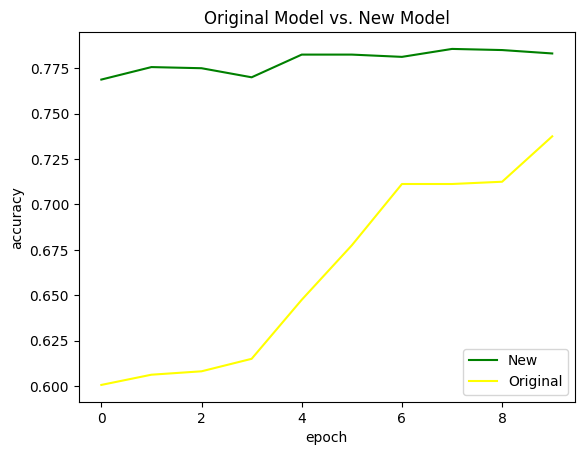

In [25]:
plt.plot(new_hist.history['accuracy'], color = 'green')
plt.plot(hist.history['accuracy'], color = 'yellow')
plt.title('Original Model vs. New Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['New', 'Original'], loc='lower right')
plt.show();

As we can see from the graph above, the new model was far more accurate than the original, although the original model did start to catch up after 10 epochs. The new model did not get siginificantly more accurate over more epochs, whereas the original model did.

The new model performed better from an accuracy standpoint and was also faster than the original. This is most likely due to the batch normalization that was added to the model.

### Predicting test and creating submission file

In [15]:
img_gen_test = ImageDataGenerator(rescale=1./255)

data_test = img_gen_test.flow_from_dataframe(
    dataframe = df_test,
    x_col='id',
    directory=test_folder,
    class_mode=None,
    batch_size=batch_size,
    target_size=(64, 64),
    shuffle=False)

Found 57458 validated image filenames.


In [16]:
predictions = new_model.predict(data_test, verbose=1)

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 431s 7ms/step


In [17]:
pred = np.transpose(predictions)[0]

print(pred)

submission_df = pd.DataFrame()
submission_df['id'] = df_test['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, pred))

print(submission_df.head())

submission_df['label'].value_counts()

[0.49210623 0.49180365 0.4943814  ... 0.49160156 0.4937979  0.4936287 ]
                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      0
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      0
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0


label
0    57024
1      434
Name: count, dtype: int64

In [18]:
submission_df.to_csv('/kaggle/working/submission-test.csv', index=False)